## K-means

In [1]:
import time
import sys
! pip install numpy
import numpy as np
! pip install matplotlib
import matplotlib.pyplot as plt

import math
import os
from matplotlib.pyplot import imread
! pip install patchify
from patchify import patchify

from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import random
random.seed(1)
import cv2
import functools
import os
! pip install torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from torch import nn



These programming exercises will focus on K-means clustering. 

If you're unsure of how k-means works, read this very helpful and freely available online breakdown from Stanford's CS221 course; https://stanford.edu/~cpiech/cs221/handouts/kmeans.html


In [2]:
from sklearn.decomposition import PCA
import os
from matplotlib.pyplot import imread
train_images = []
path = "../output"
for file in os.listdir(path):
    if file.endswith(".jpg"):
        im = cv2.imread(path + "/" + file)
        y = list(im.ravel())
        y = np.array(y)
        #im =imread(path + "/" + file)
        train_images.append(y)
# plt.imshow(train_images[0])  #not using since it is 1D array
# plt.show()
train_images[0]

C:\Users\jinpaiduizhang\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\jinpaiduizhang\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [3]:
#X = np.load("./data.npy")
X = np.array(train_images)
m,n = X.shape
pca = PCA(n_components = min(m,n),random_state=2023)
Y = X.T
pca.fit(X)

# k=4

PCA(copy=True, iterated_power='auto', n_components=496, random_state=2023,
    svd_solver='auto', tol=0.0, whiten=False)

In [4]:
X_pca = pca.transform(X)
print(X_pca.shape)
X= X_pca

(496, 496)



K-means is a special, simple case of the Expectation Maximisation (EM) algorithm.

This simplified EM (k-means), is divided into two steps.

The **E-Step**, where for every sample in your dataset you find which "centroid" that datapoint is closest to that sample, and record that information.

The **M-Step**, where you move each "centroid" to the center of the samples which were found to be closest to it in the **E-Step**.

Each *centroid* is simply an estimated mean of a cluster. If you have $1$ centroid, then this centroid will become the mean of all your data.

Centroids are initially random values, and the k-means algorithm attempts to modify them so that each one represents the center of a cluster.

We have implemented a centroids initialization function.

In [5]:
from random import sample
def initialise_parameters(m, X):
    C = sample(list(X), k=m)
    return np.array(C)

# C = initialise_parameters(4, X)
# print(C)




---
   **1.1:** $E\_step(C, X) = L$, where $L$ is a matrix of the same dimension of the dataset $X$.
   
   This function is is the **E-Step** 

---

In [6]:
def distance(centre,sample):
    return(math.sqrt(np.sum((centre-sample)**2)))
#     return(math.sqrt((centre[0]-sample[0])**2+(centre[1]-sample[1])**2))
def E_step(C, X):
    L = np.zeros(X.shape)
    for i in range(0, X.shape[0]):
        ags = np.argmin(np.linalg.norm(C - X[i], axis = 1))
        L[i] = C[ags]
    return L
# L = E_step(C, X)/

# fig = plt.figure(figsize=(16, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(L[:, 0], L[:, 1],L[:,2"])
# plt.show()
# print(L)

**TASK 1.2:** Create a function $M\_step(C, X, L) = C$ which returns $C$ modified so that each centroid in $C$ is placed in the middle of the samples assigned to it. This is the **M-Step**.

In other words, make each centroid in $C$ the average of all the samples which were found to be closest to it during the **E-step**. This is also called the "update step" for K-means.

---

**HINT:** https://docs.scipy.org/doc/numpy/reference/generated/numpy.array_equal.html

In [7]:
def M_step(C, X, L):
    new_C = np.zeros(C.shape)
    for i in range(0, C.shape[0]):
        centroid = C[i]
        count = np.count_nonzero(np.all(L == centroid, axis = 1))
        new_C[i] = np.sum(X[np.all(L == C[i], axis = 1)], axis = 0) / count
    return new_C

# print('Before:')
# print(C)
# print('\nAfter:')
# new_C = M_step(C, X, L)
# print(new_C)

Implement $kmeans(X, m, threshold) = C, L$ which takes a dataset $X$ (of any dimension) and a scalar value $m$ and a scalar $threshold$ as input. 

In [8]:

def kmeans(X, m, threshold):
    L = np.zeros(X.shape)
    C = initialise_parameters(m, X)
    diff = float('inf')
    loss_prev = float('inf')
    while diff > threshold:
        L = E_step(C, X)
        loss_cur = np.sum((np.linalg.norm(X - L, axis=1)**2))
        diff = abs(loss_prev - loss_cur)
        loss_prev = loss_cur
        C = M_step(C, X, L)
    # due to the fact that we pair the data point and cluster centroid
    # by the value in L match the value in C, we need to do E_step one more time
    L = E_step(C, X)
    return C, L

# C_final, L_final = kmeans(X, k, 1e-6)

print('\nFinal Parameters:')
# print(C_final)
def allocator(X, L, c):
    cluster = []
    for i in range(L.shape[0]):
        if np.array_equal(L[i, :], c):
            cluster.append(X[i, :])
    return np.asarray(cluster)



Final Parameters:


In [9]:
def evaluation(X, L_final, C_final):
    length = 0
    total_distance = 0 #evaluation
    for i in range(k):
        cluster = allocator(X, L_final, C_final[i, :])
#         print("the "+str(i)+" cluster is: "+str(cluster[:,i]))
        length += len(cluster)
        for d in range(cluster.shape[0]):
            total_distance += distance(C_final[i,:],cluster[d,:])
    
    return length,total_distance
# length,total_distance = evaluation(X, L_final, C_final)
# print("sum "+str(length))
# print("The distance is "+ str(total_distance))

8 when cluster = 8evaluation outcome is: 11144254.572216941
9 when cluster = 9evaluation outcome is: 10897883.668272763
10 when cluster = 10evaluation outcome is: 10940706.660851035
11 when cluster = 11evaluation outcome is: 10782062.50632595
12 when cluster = 12evaluation outcome is: 10655511.898069628
13 when cluster = 13evaluation outcome is: 10588273.766482065
14 when cluster = 14evaluation outcome is: 10425028.15065911
15 when cluster = 15evaluation outcome is: 10566368.616669348
16 when cluster = 16evaluation outcome is: 10324153.739490025
17 when cluster = 17evaluation outcome is: 10312526.643050965
18 when cluster = 18evaluation outcome is: 10265343.519583318
19 when cluster = 19evaluation outcome is: 10020790.539341489


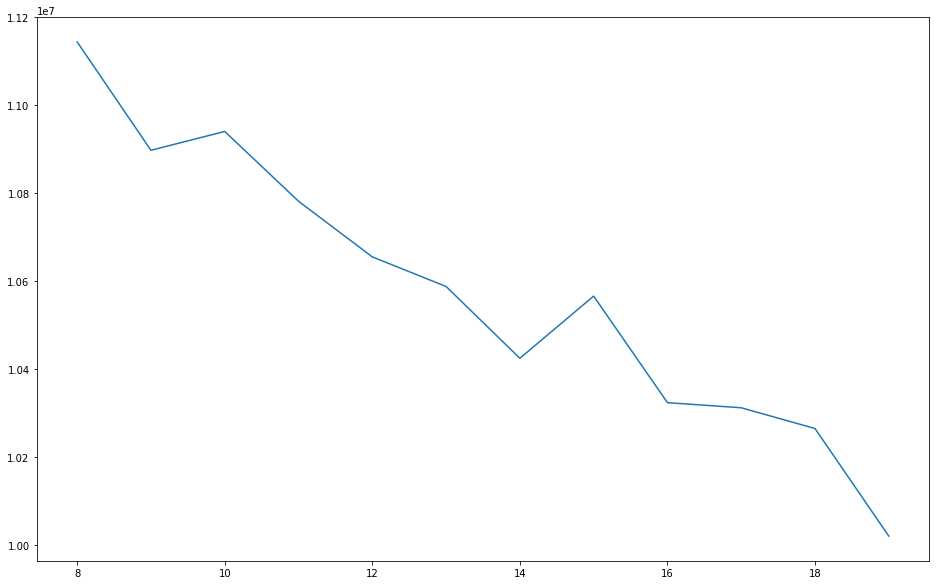

In [15]:
xaxis = []
yaxis = []
wrongtimes = 0
for i in range(8,20):
    xaxis.append(i)
    k = i
    C_final, L_final = kmeans(X, k, 1e-6)
    length,total_distance = evaluation(X, L_final, C_final)
    yaxis.append(total_distance)
    print(k,end = " ")
    if(length!=X.shape[0]):
        print("Error, when i = "+str(i)+" the clusters start overlapping: "+str(length))
        wrongtimes += 1
    else:
        print("when cluster = "+str(k)+ "evaluation outcome is: "+str(total_distance))
        wrongtimes = 0
    
    if(wrongtimes>=5):
        break
        
fig = plt.figure(figsize=(16, 10))
plt.plot(xaxis,yaxis)
plt.show()

In [13]:
yaxis[:20]

[13919534.645874582,
 13142963.037445504,
 12371424.027790403,
 12134316.425108725,
 12060524.967911735,
 11328955.563477516,
 11191475.785520628,
 10994184.736310164,
 10871694.265812716,
 10789263.676105438,
 10576513.16412319,
 10525746.195083572,
 10333200.441340882,
 10358272.861433754,
 10648045.69741975,
 10436494.845371531,
 10243836.557645874,
 10145287.160824101,
 10216822.740370922,
 9989471.946566893]